# Naîve Bayes Clasiffier and Generator
In this notebook, a Naive Bayes application is proposed for image classification of the MNIST dataset.

The Naive Bayes classification algorithm is a probabilistic classifier. It is based on probability models that incorporate strong independence assumptions. Often, the independence assumptions do not have an impact on reality. Therefore, they are considered as naive. You can derive probability models by using Bayes' theorem (credited to Thomas Bayes). Depending on the nature of the probability model, you can train the Naive Bayes algorithm in a supervised learning setting. (IBM)

## Data Import

In [39]:
from keras.datasets import mnist # dataset mnist
from scipy.stats import mode
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as matplot
import matplotlib
import random
matplot.rcdefaults()
from IPython.display import display, HTML
from itertools import chain
from sklearn.metrics import confusion_matrix
import seaborn as sb
import time

# acurracy metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [40]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()

This dataset consists of hand-written digit images and their corresponding labels (numbers 0 to 9).

The **keras.datasets.mnist.load_data()** function is used to load the dataset. This function returns two tuples: one for the training set and one for the test set.

In [41]:
print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))

X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


The training set contains 60k images and the testing set contains 10k images.

## Training set
Below are the first 3 elements of the training dataset.

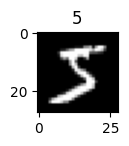

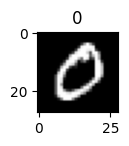

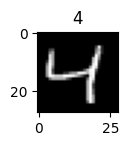

In [42]:
for i in range(3):
  matplot.subplot(4, 3, 1 + i)
  matplot.imshow(train_X[i], cmap=matplot.get_cmap('gray'))
  matplot.title(train_y[i])
  matplot.show()

## Testing set
Below are the first 3 elements of the testing dataset.

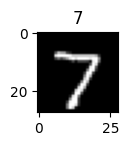

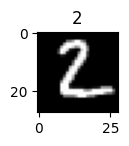

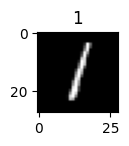

In [43]:
for i in range(3):
  matplot.subplot(4, 3, 1 + i)
  matplot.imshow(test_X[i], cmap=matplot.get_cmap('gray'))
  matplot.title(test_y[i])
  matplot.show()

## Implementation of Naive Bayes Method for image classification
For this Naive Bayes application case, the images will be represented as feature vectors. For MNIST, each pixel in the image can be treated as a feature. So each 28x28 image becomes a vector of 784 features.

 The following function "**naivebayes**" is an implementation of a Naive Bayes classifier for image classification assuming a normal distribution for the features.

In [44]:
# Image classification assuming a normal distribution
def naivebayes(train, train_lb, test, test_lb, smoothing):

    # Input variables
    n_class = np.unique(train_lb)  # List of unique classes (0 to 9)
    tr = train  # Training dataset
    te = test  # Testing dataset
    tr_lb = train_lb  # Training dataset labels
    te_lb = test_lb  # Testing dataset labels
    smoothing = smoothing  # Smoothing to avoid errors

    # Training step
    m, s, prior, count = [], [], [], []  # Empty lists to store probabilities
    for i, val in enumerate(n_class):
        sep = np.where(tr_lb == val)  # Frequency of the class
        count.append(len(sep[0]))  # Number of training examples in that class
        prior.append(len(sep[0]) / len(tr_lb))  # Proportion of training examples belonging to that class
        # Normal distribution features
        m.append(np.mean(tr[sep], axis=0))  # Vector of means of features for that class
        s.append(np.std(tr[sep], axis=0))  # Standard deviations of features for that class

    # Testing step
    pred, likelihood, lcs = [], [], []
    for n in range(len(te_lb)):
        classifier = []  # list to Calculate probabilities
        sample = te[n]  # list to Test image sample
        ll = []  # list to Calculate ranking
        for i, val in enumerate(n_class):
            m1 = m[i]  # Mean of image features
            var = np.square(s[i]) + smoothing  # Variance of features
            # Normal probability distribution
            prob = 1 / np.sqrt(2 * np.pi * var) * np.exp(-np.square(sample - m1) / (2 * var))
            result = np.sum(np.log(prob))  # Image probability by label
            classifier.append(result)  # Probability vector labels by image
            ll.append(prob)  # Probabilities by label by image

        # print(np.argmax(classifier))  # Probability vector
        pred.append(np.argmax(classifier))  # Most probable label by image
        likelihood.append(ll)  # All probabilities by image
        lcs.append(classifier)

    return pred, likelihood

In [45]:
# Classification based on pixel frequency
def naivebayes_discrete(train, train_lb, test, test_lb, smoothing):
    n_class = np.unique(train_lb)  # Unique class labels in the training data
    tr = train  # Training data
    te = test  # Testing data
    tr_lb = train_lb  # Training labels
    te_lb = test_lb  # Testing labels
    smoothing = smoothing  # Smoothing parameter
    st = time.time()  # Record start time for execution timing

    # Training step
    histograms = []  # List to store histograms for each class
    for val in n_class:
        sep = tr[tr_lb == val]  # Images of the current class
        hist, _ = np.histogram(sep, bins=256, range=(0, 256))  # Compute histogram
        histograms.append(hist)

    # Testing step
    pred = []  # List to store predicted class labels
    likelihood = []  # List to store likelihood probabilities
    for img in te:
        classifier = []  # List to store classifier results
        ll = []  # List to store likelihood probabilities

        for i, val in enumerate(n_class):
            hist = histograms[i]
            prob = (hist[img] + smoothing) / (np.sum(hist) + smoothing * 256)  # Naive Bayes probability calculation
            result = np.prod(prob)  # Calculate the product of probabilities
            classifier.append(result)  # Store the classifier result
            ll.append(prob)  # Store the probability for likelihood computation

        pred.append(np.argmax(classifier))  # Predict the class label with the highest probability
        likelihood.append(ll)  # Store likelihood probabilities

    return pred, likelihood


In [46]:
# Bayesian Naive Bayes Classification
def naivebayes_bayesian(train, train_lb, test, test_lb, smoothing):
    # Input variables
    n_class = np.unique(train_lb)  # Unique class labels in the training data
    tr = train  # Training data
    te = test  # Testing data
    tr_lb = train_lb  # Training labels
    te_lb = test_lb  # Testing labels
    smoothing = smoothing  # Smoothing parameter

    # Training step
    prior = []  # Prior probability of each class
    conditional_probs = []  # Conditional probabilities of pixels
    for val in n_class:
        sep = tr[tr_lb == val]  # Images of the current class
        prior.append(len(sep) / len(tr))  # Calculate prior probability

        # Estimate conditional probabilities of pixels for each class
        conditional_prob = []
        for pixel_value in range(256):  # Pixel values from 0 to 255 (gray scale range)
            # Calculate conditional probability using Bayes' Theorem
            pixel_count = np.sum(sep == pixel_value)  # Count of the pixel value in the class
            total_count = len(sep)  # Total number of pixels in the class
            prob = (pixel_count + smoothing) / (total_count + smoothing * 256)
            conditional_prob.append(prob)
        conditional_probs.append(conditional_prob)

    # Testing step
    pred = []  # List to store predicted class labels
    likelihood = []  # List to store likelihood probabilities
    for img in te:
        classifier = []  # List to store classifier results
        ll = []  # List to store likelihood probabilities

        for i, val in enumerate(n_class):
            class_prob = np.log(prior[i])  # Calculate the log prior probability
            for pixel_value in img.flatten():  # Ensure img is one-dimensional
                # Add the log probability of each pixel's conditional probability
                class_prob += np.log(conditional_probs[i][pixel_value])
            classifier.append(class_prob)

        pred.append(np.argmax(classifier))  # Predict the class label with the highest probability
        likelihood.append(ll)  # Store likelihood probabilities

    return pred, likelihood


## Testing model

Usually, data is commonly split in a proportion (70/30) for training and testing. In this case, advantage was taken of the division performed in the 'keras.datasets' package.

In [47]:
n_img = 10000 # number of images from the test dataset for performing the test

In [48]:
# Classification based on pixel frequency
nbd = naivebayes_discrete(train=train_X, train_lb=train_y, test=test_X[:n_img], test_lb=test_y[:n_img], smoothing=1e-5)
nbd_pred = nbd[0]

In [49]:
# Image classification assuming a normal distribution
nb = naivebayes(train=train_X, train_lb=train_y, test=test_X[:n_img], test_lb=test_y[:n_img], smoothing=1000)
nb_pred = nb[0]

In [50]:
# Bayesian Naive Bayes Classification
nbb = naivebayes_bayesian(train=train_X, train_lb=train_y, test=test_X[:n_img], test_lb=test_y[:n_img], smoothing=1e-5)
nbb_pred = nbb[0]

## Perform the test

Out of the three implemented methods, the one that achieves a better fit or accuracy in the classification of images is the one assuming normality for the pixel distribution, as can be observed below.

In [51]:
# Define the predicted variable to use to perform the tests
# pred_ys = [nb_pred, nbd_pred, nbb_pred]
pred_y = nb_pred

In [52]:
# clases de numeros en el vector de prediccion
list(set(pred_y))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [53]:
# Calculate predicted labels
# Calculate metrics
accuracy = accuracy_score(test_y[:n_img], pred_y)
precision = precision_score(test_y[:n_img], pred_y, average='weighted')
recall = recall_score(test_y[:n_img], pred_y, average='weighted')
f1 = f1_score(test_y[:n_img], pred_y, average='weighted')
confusion = confusion_matrix(test_y[:n_img], pred_y)

print("Test Accuracy:", accuracy)
print("Test Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("Confusion Matrix:")
print(confusion)

Test Accuracy: 0.8149
Test Precision: 0.8302880391596409
Recall: 0.8149
F1-Score: 0.8149884079035574
Confusion Matrix:
[[ 902    0    0    4    1   11   20    1   37    4]
 [   0 1096    1    4    0    0    6    0   28    0]
 [  15   36  778   31    9    5   59   14   79    6]
 [   6   34   26  814    0   18   15   11   44   42]
 [   4    6    5    0  640    4   22    0   19  282]
 [  19   28    7   94   23  574   24   11   64   48]
 [  12   22   12    1    8   24  865    0   13    1]
 [   1   38    8    4   20    0    1  837   25   94]
 [   8   67    8   36   11   17   12    4  742   69]
 [   6   16    3    9   38    1    0   15   20  901]]


In [54]:
def error_rate(confusion_matrix):
    a = confusion_matrix
    b = a.sum(axis=1)
    df = []
    for i in range(0,10):
        temp = 1-a[i][i]/b[i]
        df.append(temp)

    df = pd.DataFrame(df)
    df.columns = ['% Error rate']
    return df*100

In [55]:
error_rate(confusion)

,% Error rate
0,7.959184
1,3.436123
2,24.612403
3,19.405941
4,34.826884
5,35.650224
6,9.707724
7,18.579767
8,23.819302
9,10.703667


Naive Bayes is a good starting point for text classification and feature-independent tasks, for computer vision tasks such as image classification, better results are generally obtained with more advanced algorithms such as CNNs (Bill Tran) due to the complexity and spatial relationships in the image data.

## References

- IBM. IBM Integrated Analytics System "https://www.ibm.com/docs/en/ias?topic=integrated-analytics-systemcheck-out-integrated-analytics-system-product-hub"
- Bill Tran. Naïve Bayes vs. SVM for Image Classification
A comparison of the two most popular image classifiers "https://betterprogramming.pub/na%C3%AFve-bayes-vs-svm-for-image-classification-75c16b29a96d"